## Problem Set #[4]

MACS 30250, Dr. Evans

Linghui Wu

In [1]:
# Import libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.linalg as la

import warnings
warnings.filterwarnings("ignore")

### Exercise 2.1.

In [2]:
# Set parameters
beta = 0.96 ** 20
delta = 1 - (1 - 0.05) ** 20
sigma = 3
A = 1
alpha = 0.35
nvec = np.array([1, 1, 0.2])
SS_tol = 1e-09
f_params = (nvec, A, alpha, delta)

In [3]:
# Define auxiliary functions
def get_r(alpha, A, L, K, delta):
    return alpha * A * ((L / K) ** (1 - alpha)) - delta

def get_w(alpha, A, L, K):
    return (1 - alpha) * A * ((K / L) ** alpha)

def get_K(b2, b3):
    return b2 + b3

def get_cons(b_s, b_s_1, n_s, r, w):
    return w * n_s + (1 + r) * b_s - b_s_1

def get_util(c, sigma):
    return (c ** (1 - sigma) - 1) / (1 - sigma)

def get_MU(c, sigma=3):
    return c ** -sigma

def get_Y(alpha, A, L, K):
    return A * (K ** alpha) * (L ** (1 - alpha))

In [4]:
# Define the `feasible` function
def feasible(f_params, bvec_guess):
    nvec, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    K = get_K(b2, b3)
    L = nvec.sum()
    r = get_r(alpha, A, L, K, delta)
    w = get_w(alpha, A, L, K)
    c1 = get_cons(0, b2, nvec[0], r, w)
    c2 = get_cons(b2, b3, nvec[1], r, w)
    c3 = get_cons(b3, 0, nvec[2], r, w)
    
    b_cnstr = np.zeros(2, dtype="bool")
    
    c_cnstr = np.zeros(3, dtype="bool")
    c_cnstr[0] = c1 <= 0
    c_cnstr[1] = c2 <= 0
    c_cnstr[2] = c3 <= 0
    
    K_cnstr = np.zeros(1, dtype="bool")
    K_cnstr[0] = K <= 0
    
    
    if c_cnstr[0] ==  True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0] = True
        b_cnstr[1] = True
    if c_cnstr[1] == True:
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

#### (a)

In [5]:
bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr)
print(c_cnstr)
print(K_cnstr)

[ True False]
[ True False False]
[False]


The above results show that the nonnegativity constraint of consumption in period 1 is violated.

#### (b)

In [6]:
bvec_guess = np.array([0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr)
print(c_cnstr)
print(K_cnstr)

[False False]
[False False False]
[False]


The above results show that no constraints are violated.

#### (c)

In [7]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr)
print(c_cnstr)
print(K_cnstr)

[False False]
[False False False]
[False]


The above results show that no constraints are violated.

### Exercise 2.2.

In [8]:
# Define a function that calculates the Euler errors
def EulEqs(bvec, f_params):
    nvec, A, alpha, delta, beta = f_params
    b2, b3 = bvec
    K = get_K(b2, b3)
    L = nvec.sum()
    r = get_r(alpha, A, L, K, delta)
    w = get_w(alpha, A, L, K)
    c1 = get_cons(0, b2, nvec[0], r, w)
    c2 = get_cons(b2, b3, nvec[1], r, w)
    c3 = get_cons(b3, 0, nvec[2], r, w)
    MU1 = get_MU(c1)
    MU2 = get_MU(c2)
    MU3 = get_MU(c3)
    
    Eul1 = beta * (1 + r) * MU2 - MU1
    Eul2 = beta * (1 + r) * MU3 - MU2
    EulErr = np.array([Eul1, Eul2])
    
    return EulErr

In [9]:
# Define the `get_SS` function
def get_SS(params, bvec_guess, SS_graphs=False):
    start_time = time.clock()
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    f_params = np.array([nvec, A, alpha, delta, beta])
    b_ss = opt.root(EulEqs, bvec_guess, tol=SS_tol, args=(f_params)).x
    
    b2, b3 = b_ss
    K_ss = get_K(b2, b3)
    r_ss = get_r(alpha, A, L, K_ss, delta)
    w_ss = get_w(alpha, A, L, K_ss)
    Y_ss = get_Y(alpha, A, L, K_ss)
    c1_ss = get_cons(0, b2, nvec[0], r_ss, w_ss)
    c2_ss = get_cons(b2, b3, nvec[1], r_ss, w_ss)
    c3_ss = get_cons(b3, 0, nvec[2], r_ss, w_ss)
    c_ss = np.array([c1_ss, c2_ss, c3_ss])
    C_ss = c_ss.sum()
    EulErr_ss = EulEqs(b_ss, f_params)
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    end_time = time.clock()
    ss_time = end_time - start_time
    ss_output = {
        "b_ss": b_ss, "c_ss": c_ss, "w_ss": w_ss, "r_ss": r_ss, 
        "K_ss": K_ss, "Y_ss": Y_ss, "C_ss": C_ss,
        "EulErr_ss": EulErr_ss, "RCerr_ss": RCerr_ss,
        "ss_time": ss_time
        
    }
    
    if SS_graphs:
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, 4), c_ss, marker="o", label="Consumption in Equilibrium")
        ax.plot(np.arange(2, 4), b_ss, marker="o", label="Savings in Equilibrium")
        ax.legend()
        ax.set_title("The Steady-state Distribution of Consumption and Savings")
        plt.show();
        
    return ss_output

#### (a)

In [10]:
params = (beta, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol)
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess)
ss_output

{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.2017252935955733,
 'r_ss': 2.4330302535646116,
 'K_ss': 0.07772432611811347,
 'Y_ss': 0.6827625321696328,
 'C_ss': 0.6329012827935535,
 'EulErr_ss': array([ 1.33582034e-12, -2.67164069e-12]),
 'RCerr_ss': 3.469446951953614e-17,
 'ss_time': 0.0006270000000001552}

#### (b)

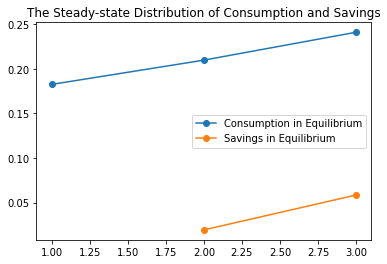

{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.2017252935955733,
 'r_ss': 2.4330302535646116,
 'K_ss': 0.07772432611811347,
 'Y_ss': 0.6827625321696328,
 'C_ss': 0.6329012827935535,
 'EulErr_ss': array([ 1.33582034e-12, -2.67164069e-12]),
 'RCerr_ss': 3.469446951953614e-17,
 'ss_time': 0.0005129999999999857}

In [11]:
params = (beta, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol)
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess, True)
ss_output

#### (c)

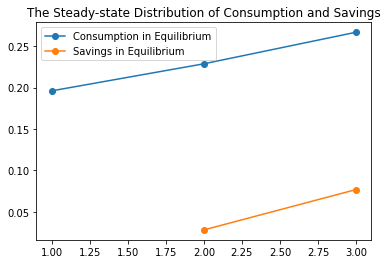

{'b_ss': array([0.02817696, 0.07686557]),
 'c_ss': array([0.19597535, 0.22861559, 0.26669216]),
 'w_ss': 0.22415231191003315,
 'r_ss': 1.8863599991452351,
 'K_ss': 0.10504252550764615,
 'Y_ss': 0.7586693633878046,
 'C_ss': 0.6912831045288896,
 'EulErr_ss': array([2.84217094e-14, 2.84217094e-14]),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.00034599999999995745}

In [12]:
params = (0.55, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol)
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess, True)
ss_output

In the new steady-state, savings, consumptions, and wages in each period are higher, while the interest rate becomes lower. Capitals, outputs and total consumptions increase.

Intuitively, when all households become more patient, people emphazise more on the later periods of their lif; so they would like to consume and save more in the future. When the savings increase, the interest rate decreases and more capitals are used by the firms. Marginal productivity of labor is higher and thus wages is larger.

### Exercise 2.3.

In [13]:
# Set parameters
L = nvec.sum()
T = 30
tol = 1e-09
xi = 0.2
eul_tol = 1e-06
max_iter = 10000
params = (beta, sigma, nvec, L, A, alpha, delta, eul_tol)

In [14]:
b_ss = get_SS(params, bvec_guess)["b_ss"]
b2_bar, b3_bar = b_ss

b21 = 0.8 * b2_bar
b31 = 1.1 * b3_bar
bvec_guess = np.array([b21, b31])

K1 = get_K(b21, b31)
K_bar = get_K(b2_bar, b3_bar)
K_path = np.linspace(K1, K_bar, T)
K_path = np.append(K_path, K_bar)

In [15]:
# Define auxiliary functions
def get_path(T, K_path, K_bar, params):
    r_path = np.zeros(T)
    w_path = np.zeros(T)
    for t in range(T):
        r_path[t] = get_r(alpha, A, L, K_path[t], delta)
        w_path[t] = get_w(alpha, A, L, K_path[t])
    
    r_bar = get_r(alpha, A, L, K_bar, delta)
    w_bar = get_w(alpha, A, L, K_bar)
    r_path = np.append(r_path, r_bar)
    w_path = np.append(w_path, w_bar)
    
    return np.array([r_path, w_path])

def EulEqs2(b32, b32_params):
    b21, b22, r_path, w_path, params = b32_params
    c1 = get_cons(b21, b32, params[2][1], r_path[0], w_path[0])
    c2 = get_cons(b32, 0, params[2][2], r_path[1], w_path[1])
    MU1 = get_MU(c1)
    MU2 = get_MU(c2)
    
    return params[0] * (1 + r_path[1]) * MU2 - MU1

def get_b32(b21, b22, r_path, w_path, params, bvec_guess):
    b32_params = [b21, b22, r_path, w_path, params]
    result = opt.root(EulEqs2, bvec_guess[0], args=b32_params, tol=params[7])
    b32 = result.x
    b32_EulErrs = result.fun
    
    return np.array([b32, b32_EulErrs])

def get_b_EulErr(b, b_params):
    t, r_path, w_path, params = b_params
    
    c21 = get_cons(0, b[0], params[2][0], 0, w_path[t])
    c22 = get_cons(b[0], b[1], params[2][1], r_path[t + 1], w_path[t + 1])
    MU21 = get_MU(c21)
    MU22 = get_MU(c22)
    Eul2 = params[0] * (1 + r_path[t + 1]) * MU22 - MU21
    
    c31 = get_cons(b[0], b[1], params[2][1], r_path[t + 1], w_path[t + 1])
    c32 = get_cons(b[1], 0, params[2][2], r_path[t + 2], w_path[t + 2])
    MU31 = get_MU(c31)
    MU32 = get_MU(c32)
    Eul3 = params[0] * (1 + r_path[t + 2]) * MU32 - MU31
    
    return np.array([Eul2, Eul3])
    
def get_b(t, r_path, w_path, params, bvec_guess):
    b_params = [t, r_path, w_path, params]
    result = opt.root(get_b_EulErr, bvec_guess, args=b_params, tol=params[7])
    b = result.x
    b_EulErrs = result.fun
    
    return np.array([b, b_EulErrs])
    
def get_errors(K_path, r_path, w_path, bmat, params):
    L = params[2].sum()
    C = L * w_path[:-1] + (1 + r_path[:-1]) * bmat[:-1, 0] - bmat[1:, 0] + (1 + r_path[:-1]) * bmat[:-1, 1] - bmat[1:, 1]
    Y = params[4] * (K_path[:-1] ** params[5]) * (L ** (1 - params[5]))
    agg_err = Y - C - K_path[1:] + (1 - params[6]) * K_path[:-1]

    return np.abs(agg_err).max()
    
def get_result(T, r_path, w_path, K_path, bvec_guess, b_ss, params):
    bmat = np.zeros((T + 1, 2))
    bmat[0, :] = bvec_guess
    EulErrs = np.zeros((T + 1, 2))
    cols = [0, 1]
    
    for t in range(T - 1):
        rows = [t + 1, t + 2]
        bmat[rows, cols], EulErrs[rows, cols] = get_b(t, r_path, w_path, params, bvec_guess)
    
    bmat[1, 1], EulErrs[1, 1] = get_b32(bmat[0, 0], bmat[0, 1], r_path, w_path, params, bvec_guess)
    max_EulErrs = np.abs(EulErrs).max(axis=0)
    agg_errs = get_errors(K_path, r_path, w_path, bmat, params)
    
    return bmat, max_EulErrs, agg_errs


def K_prime(bmat, K_bar):
    K_p_path = bmat[:-1, :].sum(axis=1)
    K_p_path = np.append(K_p_path, K_bar)
    
    return K_p_path

def TPI(T, K_path, K_bar, bvec_guess, b_ss, params, tol, max_iter):
    dist = 1e9
    i = 0
    while (dist > tol) & (i < max_iter):
        i += 1
        r_path, w_path = get_path(T, K_path, K_bar, params)
        bmat, max_EulErrs, max_agg_errs = get_result(T, r_path, w_path, K_path, bvec_guess, b_ss, params)
        K_p_path = K_prime(bmat, K_bar)
        dist = la.norm(K_p_path - K_path, 2)
        K_path = xi * K_p_path + (1 - xi) * K_path
        
    print("Max absolute Euler errors are {}.".format((max_EulErrs)))
    print("Max absolute aggregate resources constraint error is {}.".format(max_agg_errs))
    
    return K_path, r_path, w_path
    

#### (a)

In [16]:
K, r, w = TPI(T, K_path, K_bar, bvec_guess, b_ss, params, tol, max_iter)

Max absolute Euler errors are [3.21338177e-07 9.46417344e-08].
Max absolute aggregate resources constraint error is 0.019312734583687506.


#### (b)

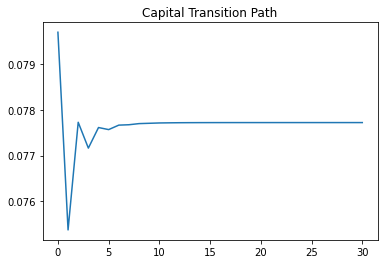

In [17]:
plt.plot(K)
plt.title("Capital Transition Path")
plt.show();

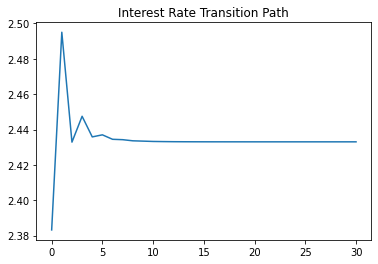

In [18]:
plt.plot(r)
plt.title("Interest Rate Transition Path")
plt.show();

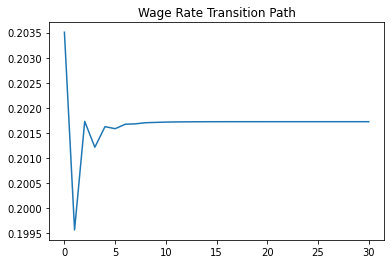

In [19]:
plt.plot(w)
plt.title("Wage Rate Transition Path")
plt.show();

#### (c)

In [20]:
K_dist = np.abs(K - K_bar)
err = 1e-05
loc1 = np.where(K_dist < err)[0]
print("The number of periods taken by the economy to get within 1e-05 pf the steady-state aggregate capital of stock capital is {}.".format(loc1.min()))
loc2 = loc1[-len(np.ediff1d(loc1) == 1)]
print("\nThe number of periods from which the economy stays with 1e-05 of the steady-state aggregate capital of stock capital is {}.".format(loc2))

The number of periods taken by the economy to get within 1e-05 pf the steady-state aggregate capital of stock capital is 2.

The number of periods from which the economy stays with 1e-05 of the steady-state aggregate capital of stock capital is 10.
